Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Files already downloaded and verified
Files already downloaded and verified
Training Data:  tensor([[-1.2854, -1.5955, -1.4598,  ...,  0.5100, -0.5825, -0.8167],
        [ 0.5562,  0.0134, -0.3936,  ...,  0.4905,  0.5491,  0.5881],
        [ 2.5141,  2.4753,  2.4753,  ..., -0.6020, -0.6020, -0.5825],
        ...,
        [ 0.9633,  1.4479,  1.5836,  ...,  0.1979, -1.2654, -1.5971],
        [-1.8863, -1.2854, -1.1303,  ..., -1.5190, -1.3629, -1.4215],
        [-1.2272, -1.6537, -1.2466,  ...,  0.2564,  0.1979,  0.0418]])
Training Data Label:  tensor([6, 9, 9,  ..., 3, 7, 1])
Positive Data:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.5100, -0.5825, -0.8167],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4905,  0.5491,  0.5881],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.6020, -0.6020, -0.5825],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1979, -1.2654

100% 3400/3400 [01:16<00:00, 44.42it/s]


Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)


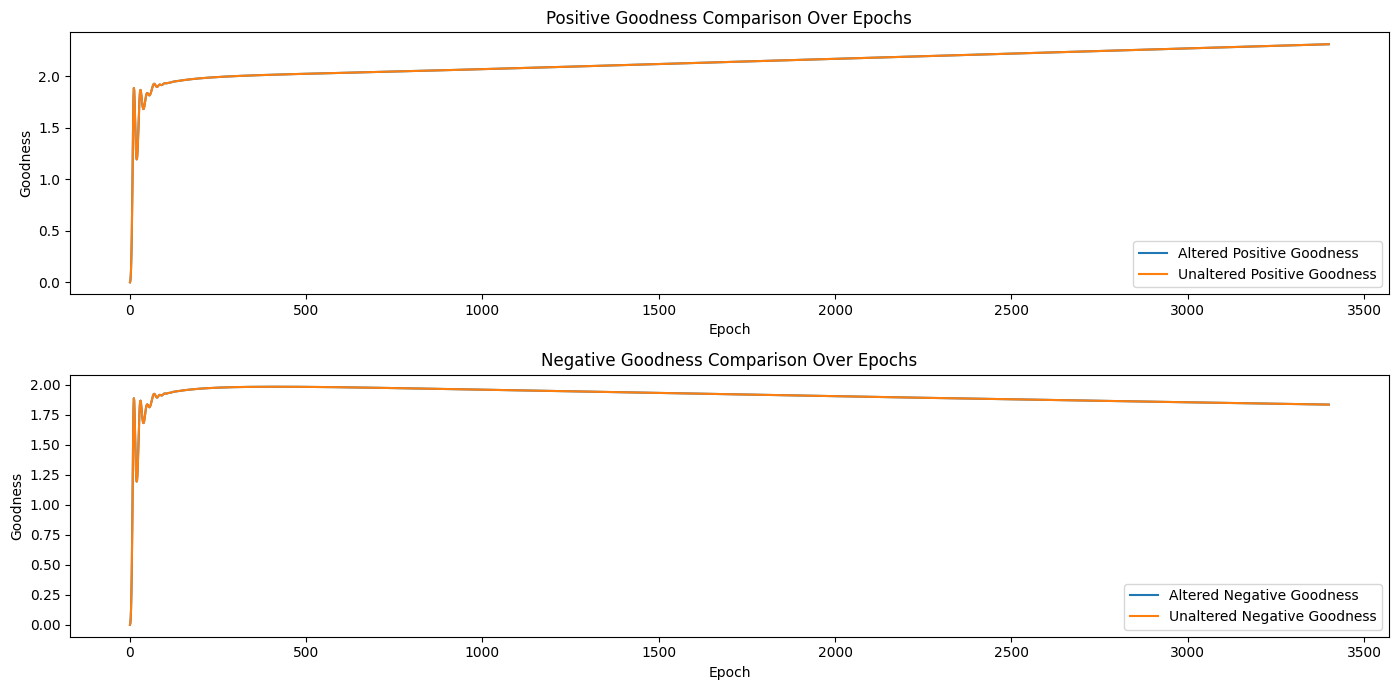

Training Layer 1 ...


100% 3400/3400 [00:41<00:00, 81.78it/s]


Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)


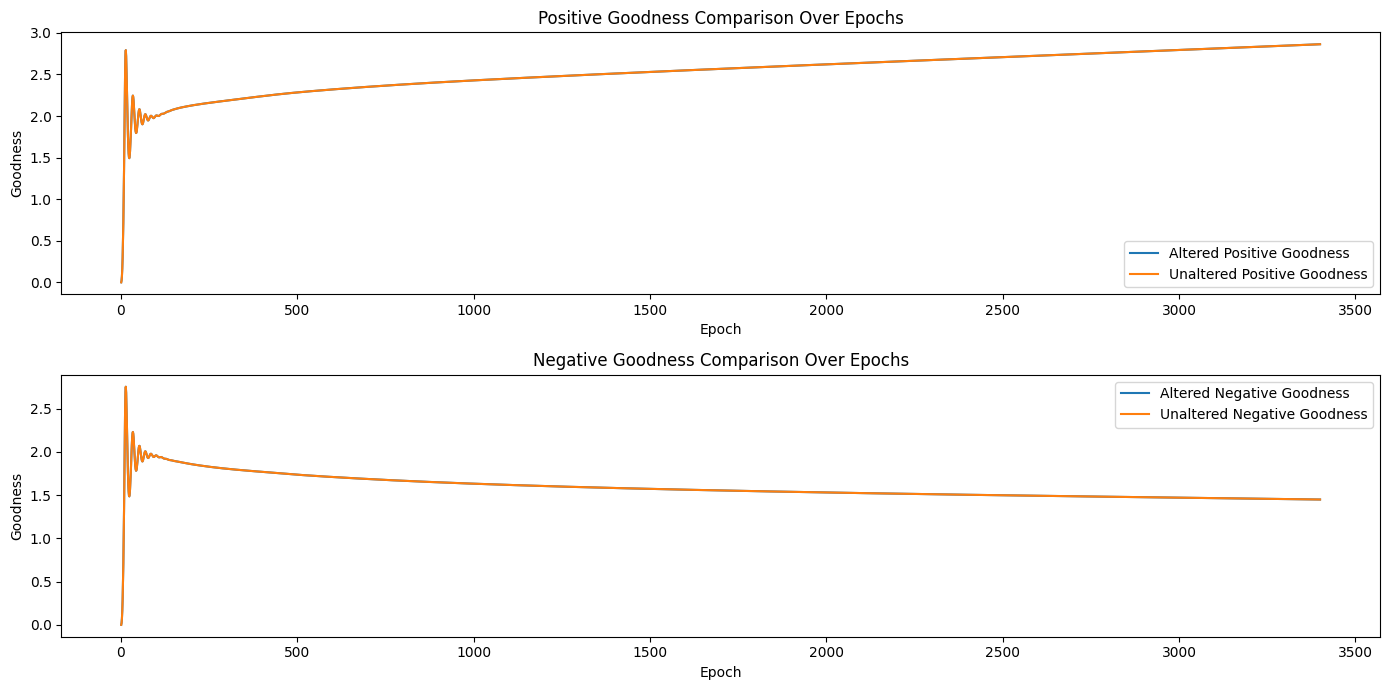

Training Layer 2 ...


100% 3400/3400 [00:42<00:00, 80.79it/s]


Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)


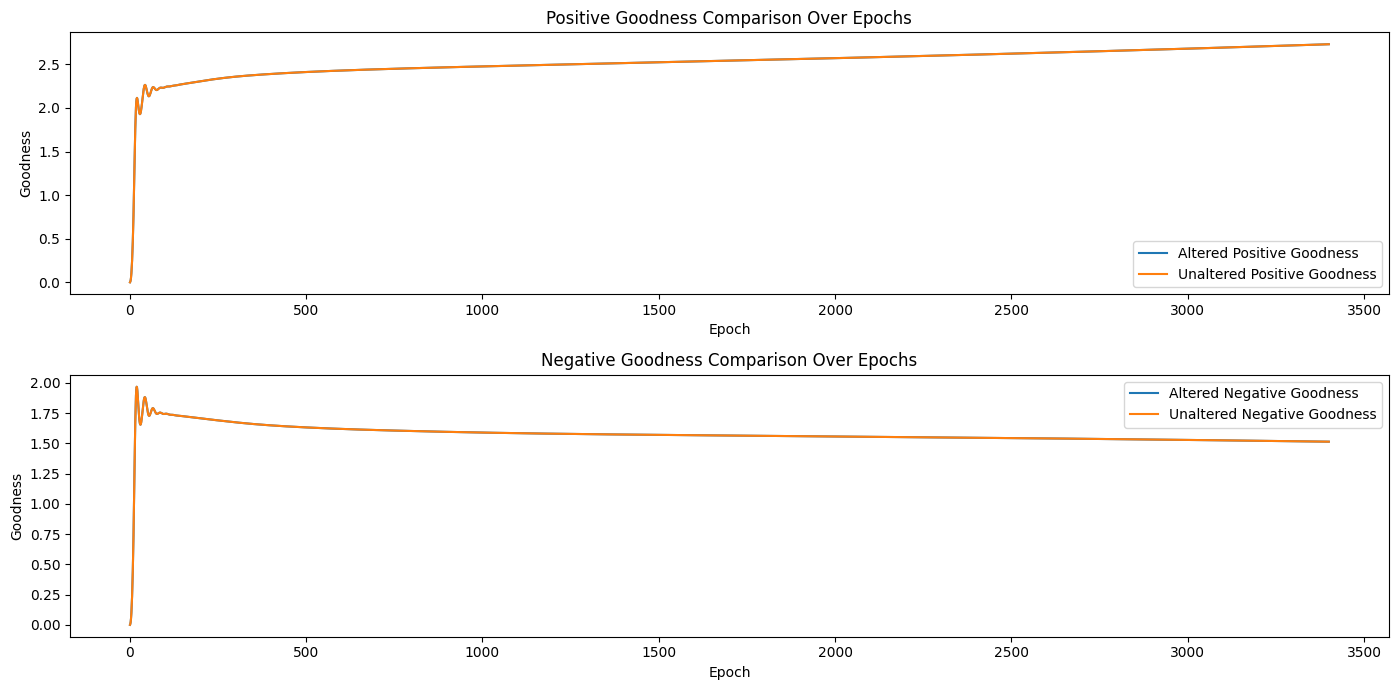

Training Accuracy:  0.5268999934196472
Testing Accuracy:  0.41616666316986084


In [49]:
!pip install tqdm
!pip install matplotlib

import random

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda



from tqdm import tqdm
from torch.optim import Adam
import torch.nn as nn

from torch import Tensor
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam

number_of_epochs = 3400


class Layer(nn.Linear):
    layer_weights = nn.Parameter(torch.ones(3, 800).cuda())
    def __init__(self, in_features, out_features, bias=True, device=None, d_type=None, is_hinge_loss=False):
        super().__init__(in_features, out_features, bias, device, d_type)
        self.activation = torch.nn.ReLU()
        self.learning_rate = 0.01
        self.optimizer = Adam(self.parameters(), lr=self.learning_rate)
        # self.layer_weights = nn.Parameter(torch.ones(6, 800))
        self.threshold = 2.0
        self.num_of_epochs = number_of_epochs
        self.is_hinge_loss = is_hinge_loss
        self.weight_optimizer = Adam([Layer.layer_weights], lr=0.0)  # Optimizer for layer_weights

    def forward(self, input: Tensor) -> Tensor:
        normalized_input = input / (input.norm(2, 1, keepdim=True) + 1e-4)
        output = torch.mm(normalized_input, self.weight.T) + self.bias.unsqueeze(0)
        return self.activation(output)

    def hinge_loss(self, positive_goodness, negative_goodness, delta=1.0, is_second_phase=False):
        if is_second_phase:
            threshold = self.threshold * 2
        else:
            threshold = self.threshold
        positive_loss = torch.clamp(delta - (positive_goodness - threshold), min=0)
        negative_loss = torch.clamp(delta - (threshold - negative_goodness), min=0)
        return torch.cat([positive_loss, negative_loss]).mean()

    def exponential_hinge_loss(self, positive_goodness, negative_goodness, delta=1.0, is_second_phase=False):
        if is_second_phase:
            threshold = self.threshold * 2
        else:
            threshold = self.threshold
        positive_loss = torch.exp(torch.clamp(delta - (positive_goodness - threshold), min=0)) - 1
        negative_loss = torch.exp(torch.clamp(delta - (threshold - negative_goodness), min=0)) - 1
        return torch.cat([positive_loss, negative_loss]).mean()

    def soft_plus_loss(self, positive_goodness, negative_goodness, is_second_phase=False):
        if is_second_phase:
            threshold = self.threshold * 3
        else:
            threshold = self.threshold
        return torch.log(1 + torch.exp(torch.cat([
            -positive_goodness + threshold,
            negative_goodness - threshold]))).mean()

    def contrastive_loss(self, positive_goodness, negative_goodness, margin=1.0):
        # Contrastive loss: positive_goodness should be higher, negative_goodness should be lower
        positive_loss = (positive_goodness - 1).pow(2)  # We want positive_goodness close to 1
        negative_loss = torch.clamp(margin - negative_goodness, min=0).pow(2)  # We want negative_goodness far from 1
        loss = (positive_loss + negative_loss).mean()
        return loss

    def margin_ranking_loss(self, positive_scores, negative_scores):
        squared_diff = (positive_scores - negative_scores).pow(2)
        loss = squared_diff.mean()
        return loss

    def plot_goodness(self, positive_goodness_history, negative_goodness_history,
                      positive_unaltered_goodness_history, negative_unaltered_goodness_history):
        epochs = range(1, self.num_of_epochs + 1)

        plt.figure(figsize=(14, 7))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, positive_goodness_history, label='Altered Positive Goodness')
        plt.plot(epochs, positive_unaltered_goodness_history, label='Unaltered Positive Goodness')
        plt.legend()
        plt.title('Positive Goodness Comparison Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Goodness')

        plt.subplot(2, 1, 2)
        plt.plot(epochs, negative_goodness_history, label='Altered Negative Goodness')
        plt.plot(epochs, negative_unaltered_goodness_history, label='Unaltered Negative Goodness')
        plt.legend()
        plt.title('Negative Goodness Comparison Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Goodness')

        plt.tight_layout()
        plt.show()

    def train_layer(self, positive_input, negative_input, layer_num):
        positive_goodness_history = []
        negative_goodness_history = []
        positive_unaltered_goodness_history = []
        negative_unaltered_goodness_history = []
        for _ in tqdm(range(self.num_of_epochs)):
            positive_output = self.forward(positive_input)  # Shape: [batch_size, 500]
            negative_output = self.forward(negative_input)
            layer_weight_row = Layer.layer_weights[layer_num, :]
            Layer.la
            positive_goodness = (positive_output.pow(2) * layer_weight_row).mean(1)  # Shape: [batch_size]
            negative_goodness = (negative_output.pow(2) * layer_weight_row).mean(1)

            positive_unaltered_goodness = positive_output.pow(2).mean(1)
            negative_unaltered_goodness = negative_output.pow(2).mean(1)

            positive_goodness_history.append(positive_goodness.mean().item())
            negative_goodness_history.append(negative_goodness.mean().item())
            positive_unaltered_goodness_history.append(positive_unaltered_goodness.mean().item())
            negative_unaltered_goodness_history.append(negative_unaltered_goodness.mean().item())
            if self.is_hinge_loss:
                loss = self.exponential_hinge_loss(positive_goodness, negative_goodness)
            else:
                loss = self.soft_plus_loss(positive_goodness, negative_goodness)

            self.optimizer.zero_grad()
            self.weight_optimizer.zero_grad()  # Clear gradients for layer_weights
            loss.backward()
            self.optimizer.step()
            self.weight_optimizer.step()  # Update layer_weights

        print(Layer.layer_weights)
        self.plot_goodness(positive_goodness_history, negative_goodness_history,
                           positive_unaltered_goodness_history, negative_unaltered_goodness_history)
        return self.forward(positive_input).detach(), self.forward(negative_input).detach()


class Network(nn.Module):

    def __init__(self, dimension_configs):
        super().__init__()
        self.layers = []
        #self.layer_weights = nn.Parameter(torch.ones(2))
        for i in range(len(dimension_configs) - 1):
            self.layers += [Layer(dimension_configs[i], dimension_configs[i + 1]).cuda()]

    def mark_data(self, data, label):
        marked_data = data.clone().cuda()
        marked_data[:, :10] = 0
        marked_data[torch.arange(marked_data.size(0)), label] = 1
        return marked_data

    def predict(self, input_data):
        goodness_per_label = []
        for label in range(10):
            marked_data = self.mark_data(input_data, label)
            goodness = []
            for layer_num, layer in enumerate(self.layers):
                marked_data = layer(marked_data)
                layer_weights = Layer.layer_weights[layer_num, :]
                goodness_value = (marked_data.pow(2) * layer_weights).mean(1)
                # goodness_value = marked_data.pow(2).mean(1)
                goodness.append(goodness_value)
            goodness_per_label.append(torch.sum(torch.stack(goodness), dim=0).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(dim=1)

    def train_network(self, positive_goodness, negative_goodness):
        #optimizer = Adam(self.parameters(), lr=0.001)
        goodness_pos, goodness_neg = positive_goodness, negative_goodness
        for i, layer in enumerate(self.layers):
            print('Training Layer', i, '...')
            goodness_pos, goodness_neg = layer.train_layer(goodness_pos, goodness_neg, i)

        # for _ in tqdm(range(50)):
        #     optimizer.zero_grad()
        #     first_layer_positive_goodness_sum = self.layers[0].forward(positive_goodness).pow(2).mean(1)
        #     first_layer_negative_goodness_sum = self.layers[0].forward(negative_goodness).pow(2).mean(1)

        #     second_layer_positive_goodness_sum = self.layers[1].forward(self.layers[0].forward(positive_goodness)).pow(
        #         2).mean(1)
        #     second_layer_negative_goodness_sum = self.layers[1].forward(self.layers[0].forward(negative_goodness)).pow(
        #         2).mean(1)

        #     positive_sum = first_layer_positive_goodness_sum * self.layer_weights[
        #         0] + second_layer_positive_goodness_sum * self.layer_weights[1]
        #     negative_sum = first_layer_negative_goodness_sum * self.layer_weights[
        #         0] + second_layer_negative_goodness_sum * self.layer_weights[1]

        #     loss = self.layers[0].soft_plus_loss(positive_sum, negative_sum, is_second_phase=True)
        #     loss.backward()
        #     optimizer.step()


        # with torch.no_grad():
        #     self.layer_weights[0] = 0.8
        #     self.layer_weights[1] = 1.2

        #print(self.layer_weights)




def load_CIFAR10_data(train_batch_size=30000, test_batch_size=6000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        CIFAR10('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        CIFAR10('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_FashionMNIST_data(train_batch_size=60000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.2860,), (0.3530,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        FashionMNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        FashionMNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_MNIST_data(train_batch_size=50000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader


def create_positive_data(data, label):
    positive_data = data.clone()
    positive_data[:, :10] = 0.0

    for i in range(positive_data.shape[0]):
        positive_data[i][label[i]] = 1.0

    return positive_data


def create_negative_data(data, label, seed=None):
    if seed is not None:
        random.seed(seed)

    negative_data = data.clone()
    negative_data[:, :10] = 0.0

    for i in range(negative_data.shape[0]):
        possible_answers = list(range(10))
        possible_answers.remove(label[i])
        false_label = random.choice(possible_answers)
        negative_data[i][false_label] = 1.0

    return negative_data


def prepare_data():
    torch.manual_seed(1234)
    training_data_loader, testing_data_loader = load_CIFAR10_data()

    training_data, training_data_label = next(iter(training_data_loader))

    testing_data, testing_data_label = next(iter(testing_data_loader))
    testing_data, testing_data_label = testing_data.cuda(), testing_data_label.cuda()

    print(f"Training Data: ", training_data)
    print(f"Training Data Label: ", training_data_label)

    training_data, training_data_label = training_data.cuda(), training_data_label.cuda()

    positive_data = create_positive_data(training_data, training_data_label)
    print(f"Positive Data: ", positive_data)

    negative_data = create_negative_data(training_data, training_data_label, seed=1234)
    print(f"Negative Data: ", negative_data)

    return positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label


if __name__ == "__main__":
    torch.cuda.empty_cache()
    torch.manual_seed(1234)
    positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label = prepare_data()
    network = Network([3072, 800, 800, 800]).cuda() #3072
    network.train_network(positive_data, negative_data)

    print("Training Accuracy: ", network.predict(training_data).eq(training_data_label).float().mean().item())

    print("Testing Accuracy: ", network.predict(testing_data).eq(testing_data_label).float().mean().item())
